In [1]:
import localcider
import protfasta
import glob
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
# from Bio.Seq import Seq
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Helvetica"
# # plt.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
oldmasterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20210128_withSeqFeatures.csv')
# masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20220729_withSeqFeatures.csv')
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')

maxActivity = max(masterDF.Activity_SCglucose)

In [3]:
# Define WT AD DF

WTindx  = [20679,]


# ActivityThresh=45373 #new thresholds from Aaron's model June 2024
ActivityThresh=  94031 # 80th percentile 20241001

# # Define the Scer WT tiles for comparison
# indx = (Orthologs_DF.SpeciesNames =='Saccharomycotina_sp|P03069|GCN4_YEAST')&(Orthologs_DF.Activity>0)
# ScertempDF = Orthologs_DF[indx]
# ScertempDF = ScertempDF.sort_values(by='NativeLocation',ascending=True)
# ScertempDF
print('%i of %i Designed tiles recovered, %.1f percent'%(sum(masterDF['Recovered']),len(masterDF),100.0*sum(masterDF['Recovered'])/len(masterDF)))
print('%i of %i Designed tiles were measured in both replicates, %.1f percent'%(sum(masterDF.Stdev_BYS4_BioReps>0),len(masterDF),100.0*sum(masterDF.Stdev_BYS4_BioReps>0)/len(masterDF)))

18947 of 20731 Designed tiles recovered, 91.4 percent
10854 of 20731 Designed tiles were measured in both replicates, 52.4 percent


In [4]:
masterDF['TotalReads_SCglucose']=masterDF.TotalReads_BioRepA_BYS4+masterDF.TotalReads_BioRepB_BYS4
temp = masterDF[masterDF.TotalReads_SCglucose>0]
min(temp.TotalReads_SCglucose)

126.0

In [5]:
masterDF.columns

Index(['Unnamed: 0', 'ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', '(20703, 'Name')', '(20707, 'Name')', 'Start',
       'Recovered', 'Charge', 'HydrophobicityKD', 'HydrophobicityWW', 'Kappa',
       'Omega', 'OmegaWFY_DE', 'OmegaWFYL_DE', 'OmegaWF_D', 'Disorder', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y', 'Aromatics', 'WFYL', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WF]',
       '[DE][L]', '[DE].[WFY]', '[DE]..[WFY]', 'FF', 'F.F', 'F..F',
       '[FY].....[FY]DF', 'D.F', 'D..F', 'FD', 

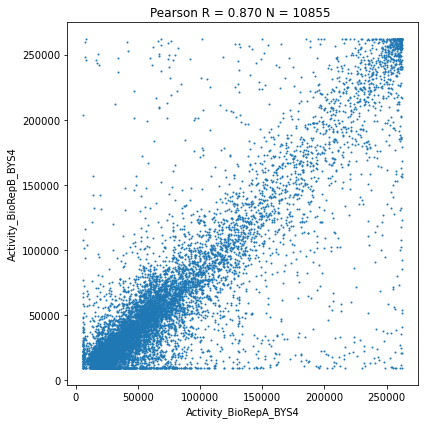

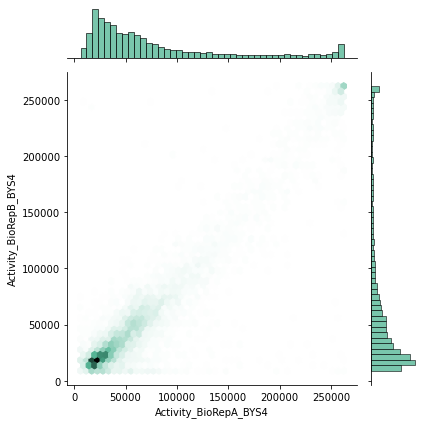

Index(['Unnamed: 0', 'ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', '(20703, 'Name')', '(20707, 'Name')', 'Start',
       'Recovered', 'Charge', 'HydrophobicityKD', 'HydrophobicityWW', 'Kappa',
       'Omega', 'OmegaWFY_DE', 'OmegaWFYL_DE', 'OmegaWF_D', 'Disorder', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y', 'Aromatics', 'WFYL', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WF]',
       '[DE][L]', '[DE].[WFY]', '[DE]..[WFY]', 'FF', 'F.F', 'F..F',
       '[FY].....[FY]DF', 'D.F', 'D..F', 'FD', 

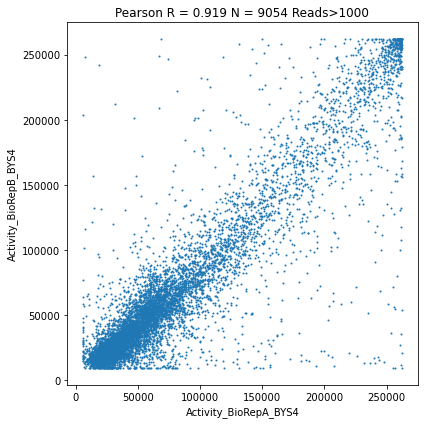

In [6]:
masterDF.plot.scatter(x='Activity_BioRepA_BYS4',y='Activity_BioRepB_BYS4',s=1,figsize=(6, 6))
temp = masterDF[['Activity_BioRepA_BYS4','Activity_BioRepB_BYS4']]
a = temp.corr()
indx =( temp.Activity_BioRepA_BYS4 > 0) &(temp.Activity_BioRepB_BYS4>0)
plt.title('Pearson R = %.3f N = %i ' % (a.values[0,1],sum(indx)))
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility.pdf')
plt.show()
sns.jointplot(x='Activity_BioRepA_BYS4',y='Activity_BioRepB_BYS4', data=masterDF, kind="hex", color="#4CB391")
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility_joinplot.pdf')
plt.show()

readThresh = 1000
indx = (masterDF.TotalReads_BioRepA_BYS4 >readThresh)&(masterDF.TotalReads_BioRepB_BYS4>readThresh)
temp = masterDF[indx]
temp = temp[['Activity_BioRepA_BYS4','Activity_BioRepB_BYS4']]

temp.plot.scatter(x='Activity_BioRepA_BYS4',y='Activity_BioRepB_BYS4',s=1,figsize=(6, 6))
a = temp.corr()
indx =( temp.Activity_BioRepA_BYS4 > 0) &(temp.Activity_BioRepB_BYS4>0)
plt.title('Pearson R = %.3f N = %i Reads>%s' % (a.values[0,1],sum(indx),readThresh))
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility_highReadDepth.pdf')

masterDF.columns

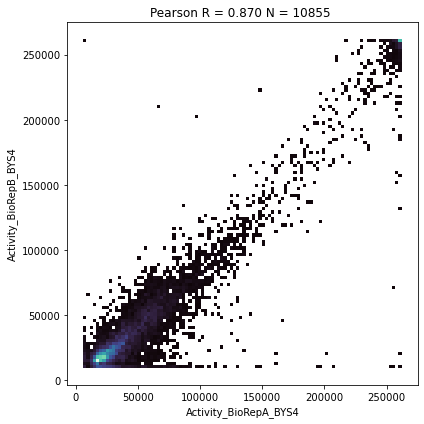

In [7]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(x='Activity_BioRepA_BYS4',y='Activity_BioRepB_BYS4', data=masterDF, s=2,color='0.15')
sns.histplot(x='Activity_BioRepA_BYS4',y='Activity_BioRepB_BYS4', data=masterDF, bins=100, pthresh=.01, cmap="mako")
temp = masterDF[['Activity_BioRepA_BYS4','Activity_BioRepB_BYS4']]
a = temp.corr()
indx =( temp.Activity_BioRepA_BYS4 > 0) &(temp.Activity_BioRepB_BYS4>0)
plt.title('Pearson R = %.3f N = %i ' % (a.values[0,1],sum(indx)))
plt.tight_layout()
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility_hist.pdf')
plt.show()

In [8]:
# load the data from Sort 2 using the PerfectMatch analysis (Bowtie caused problems)
Sort2_DF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20230414_withSeqFeatures.csv')
masterDF['Activity_SCglucose_BYS2_PerfectMatch']= Sort2_DF.Activity_SCglucose_BYS2_PerfectMatch


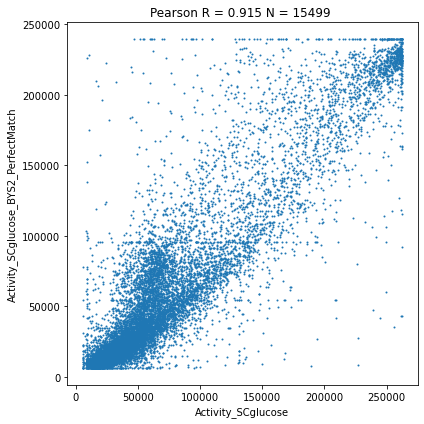

In [9]:

masterDF.plot.scatter(x='Activity_SCglucose',y='Activity_SCglucose_BYS2_PerfectMatch',s=1,figsize=(6, 6))

temp = masterDF[['Activity_SCglucose','Activity_SCglucose_BYS2_PerfectMatch']]
a = temp.corr()
indx =( temp.Activity_SCglucose > 0) &(temp.Activity_SCglucose_BYS2_PerfectMatch>0)
plt.title('Pearson R = %.3f N = %i ' % (a.values[0,1],sum(indx)))
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/CompareSorts.pdf')

In [10]:
Controls = masterDF[-52:]

renameDict2 ={}
for seq in Controls.Name:
    seq2 = seq.replace('_0','')
    seq2 = seq2.replace('_',' ')
    seq2 = seq2.replace('2A',' > A')
    print("'%s':'%s',"%(seq,seq2))
    renameDict2[seq]="'%s':'%s',"%(seq,seq2)
renameDict = {'GAL4_AD1_0':'Gal4 AD1',
'GAL4_AD1_Aro2A_0':'Gal4 AD1 Aro > A',
'GAL4_AD1_L2A_0':'Gal4 AD1 L > A',
'GCN4_CAAD40_0':'Gcn4 CAAD 101-140',
'GCN4_CAAD40_WLF_A_0':'Gcn4 CAAD WxxLF > A',
'GCN4_CAAD40_MFYL_A_0':'Gcn4 CAAD MFxYxxL > A',
'GCN4_CAAD40_7As_0':'Gcn4 CAAD MFxYxxL,WxxLF > A',
'War1_Cterm_0':'War1 AD',
'GCN4alt_0':'Gcn4 altCAAD 90-129',
'GCN4alt_FF_AA_0':'Gcn4 altCAAD FF > A',
'GCN4alt_MFYL_A_0':'Gcn4 altCAAD MFxYxxL > A',
'GCN4alt_WLF_A_0':'Gcn4 altCAAD WxxLF > A',
'GCN4alt_ALLAS_0':'Gcn4 altCAAD FF,MFxYxxL,WxxLF > A',
'GCN4alt_ARO_A_0':'Gcn4 altCAAD Aro > A',
'GCN4alt_L_A_0':'Gcn4 altCAAD L > A',
'Rap1_0':'Rap1 AD',
'Rap1_L2A_0':'Rap1 AD L > A',
'Rap1_Aro2A_0':'Rap1 AD Aro > A',

'vp16N_0':'VP16 H1 long',
'VP16C_0':'VP16 H2',
'VP16C_F2A_0':'VP16 H2 F > A',
'VP16C_Y2A_0':'VP16 H2 Y > A',
'VP16C_L2I_0':'VP16 H2 L > I',

'VP16_HUMANLIB_0':'VP16 H1',
'VP16N_7As_0':'VP16 H1 7As',
'VP16N_F442A_0':'VP16 H1 F442 > A',
'VP16N_L2A_0':'VP16 H1 L > A',
'CITED2_0':'CITED2',
'CITED2_L2I_0':'CITED2 L > I',
'CITED2_L2A_0':'CITED2 L > A',
'CITED2_ARO2A_0':'CITED2 Aro > A',
'CITED2_LWF2A_0':'CITED2 LWF > A',
'Gnc4Lib_Charge_LOW_0':'Gnc4Lib Charge LOW',
'Gnc4Lib_Disorder_LOW_0':'Gnc4Lib Disorder LOW',
'Gnc4Lib_Charge_LOW_0':'Gnc4Lib Charge LOW',
'Gnc4Lib_ChopOrthologs_LOW_0':'Gnc4Lib ChopOrthologs LOW',
'Gnc4Lib_Charge_LOW_0':'Gnc4Lib Charge LOW',
'Gnc4Lib_MovePrimaryMotif_LOW_0':'Gnc4Lib MovePrimaryMotif LOW',
'Gnc4Lib_Kappa_LOW_0':'Gnc4Lib Kappa LOW',
'Gnc4Lib_Kappa_LOW_0':'Gnc4Lib Kappa LOW',
'Gnc4Lib_Kappa_LOW_0':'Gnc4Lib Kappa LOW',
'Gnc4Lib_HoldChargeDisorder_LOW_0':'Gnc4Lib HoldChargeDisorder LOW',
'Gnc4Lib_Charge_HIGH_0':'Gnc4Lib Charge HIGH',
'Gnc4Lib_Disorder_HIGH_0':'Gnc4Lib Disorder HIGH',
'Gnc4Lib_Charge_HIGH_0':'Gnc4Lib Charge HIGH',
'Gnc4Lib_ChopOrthologs_HIGH_0':'Gnc4Lib ChopOrthologs HIGH',
'Gnc4Lib_Kappa_HIGH_0':'Gnc4Lib Kappa HIGH',
'Gnc4Lib_Kappa_HIGH_0':'Gnc4Lib Kappa HIGH',
'Gnc4Lib_Disorder_HIGH_0':'Gnc4Lib Disorder HIGH',
'Gnc4Lib_Disorder_HIGH_0':'Gnc4Lib Disorder HIGH',
'Gnc4Lib_Charge_HIGH_0':'Gnc4Lib Charge HIGH',
'Gnc4Lib_Disorder_HIGH_0':'Gnc4Lib Disorder HIGH',
             }
tempSeries = Controls.Name
Controls['FigNames']=tempSeries.map(renameDict)

'GAL4_AD1_0':'GAL4 AD1',
'GAL4_AD1_Aro2A_0':'GAL4 AD1 Aro > A',
'GAL4_AD1_L2A_0':'GAL4 AD1 L > A',
'GCN4_CAAD40_0':'GCN4 CAAD40',
'GCN4_CAAD40_WLF_A_0':'GCN4 CAAD40 WLF A',
'GCN4_CAAD40_MFYL_A_0':'GCN4 CAAD40 MFYL A',
'GCN4_CAAD40_7As_0':'GCN4 CAAD40 7As',
'War1_Cterm_0':'War1 Cterm',
'GCN4alt_0':'GCN4alt',
'GCN4alt_FF_AA_0':'GCN4alt FF AA',
'GCN4alt_MFYL_A_0':'GCN4alt MFYL A',
'GCN4alt_WLF_A_0':'GCN4alt WLF A',
'GCN4alt_ALLAS_0':'GCN4alt ALLAS',
'GCN4alt_ARO_A_0':'GCN4alt ARO A',
'GCN4alt_L_A_0':'GCN4alt L A',
'vp16N_0':'vp16N',
'VP16C_0':'VP16C',
'VP16C_F2A_0':'VP16C F > A',
'VP16C_Y2A_0':'VP16C Y > A',
'VP16C_L2I_0':'VP16C L2I',
'Rap1_0':'Rap1',
'Rap1_L2A_0':'Rap1 L > A',
'Rap1_Aro2A_0':'Rap1 Aro > A',
'VP16_HUMANLIB_0':'VP16 HUMANLIB',
'VP16N_7As_0':'VP16N 7As',
'VP16N_F442A_0':'VP16N F44 > A',
'VP16N_L2A_0':'VP16N L > A',
'CITED2_0':'CITED2',
'CITED2_L2I_0':'CITED2 L2I',
'CITED2_L2A_0':'CITED2 L > A',
'CITED2_ARO2A_0':'CITED2 ARO > A',
'CITED2_LWF2A_0':'CITED2 LWF > A',
'Gnc4Lib_C

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_71091/831858979.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Controls['FigNames']=tempSeries.map(renameDict)


In [11]:
sum(masterDF.Activity_SCglucose>0)

18947

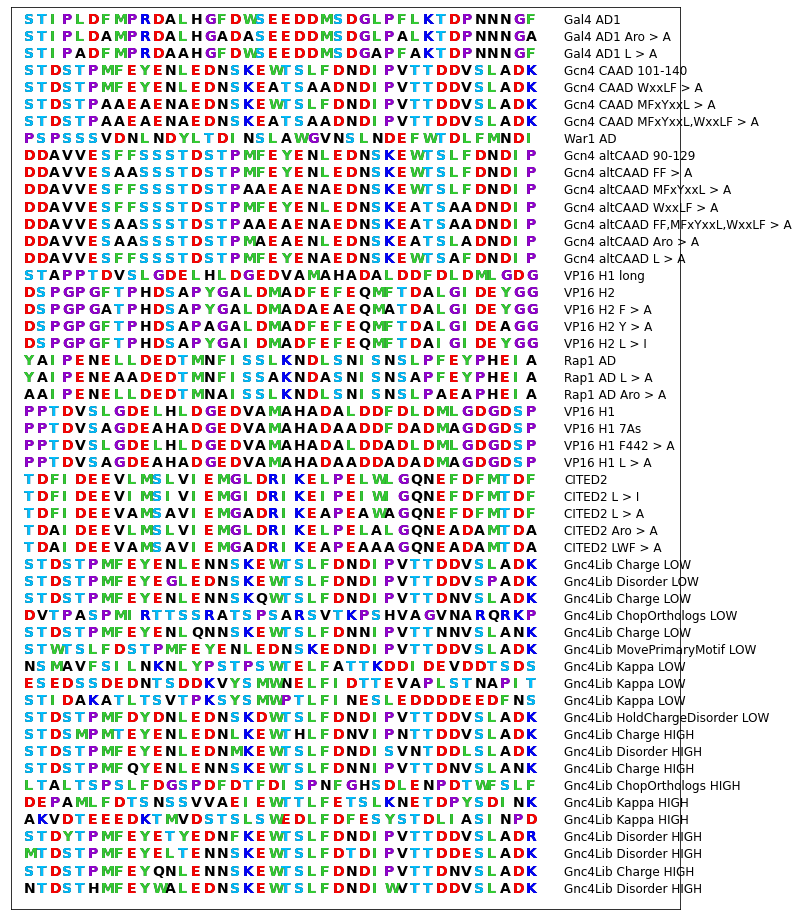

In [12]:
# plot the WT sequences of the ADs
SetofADS =['GAL4_AD1_0', 'War1_Cterm_0','Rap1_0','CITED2_0',]
AAsets= [['D','E'],['W','L','F','Y','M','I'],['K','R'],['S','T'],['P','G']]
AAset_Labels = [ 'Negatives','Hyrdophobics','Positives','Phospho sites','Prolines & Glycines']
colorSets = ['red','limegreen','blue','deepskyblue','darkviolet']
colname = 'FigNames'
filename ='All'
def visualize_AAset_DF(AD_DF,AAsets,AAset_Labels, colorSets,colname,filename):
    fig3, axes = plt.subplots( figsize=(12,len(AD_DF)*.3+1))
    ypos = 0
    for j,entry in AD_DF.iterrows():
        AD = entry.ADseq
        for pos, ADaa in enumerate(AD):
            plt.text(pos,ypos, ADaa, color='k',fontsize=14, fontweight='bold')
        for i, aaList in enumerate(AAsets):
            for pos, ADaa in enumerate(AD):
                if ADaa in aaList:
                    plt.text(pos,ypos, ADaa, color=colorSets[i],fontsize=14, fontweight='bold')
        plt.text(pos+3,ypos,entry[colname],fontsize=12)
        ypos+=1
    plt.axis([-1, pos+12, ypos,-1])
    plt.xticks([]),    plt.yticks([])
#     plt.title(entry.ADname)
    plt.savefig('Figures/ControlBarCharts/MutantList_%s.pdf'%filename)
    plt.show()
visualize_AAset_DF(Controls,AAsets,AAset_Labels,colorSets,colname,filename)

In [13]:
names= []
activities = defaultdict()
activity_std = defaultdict()
for i,row in Controls.iterrows():
    names.append( row['FigNames'])
    activities[row['FigNames']]= (row.Activity_SCglucose)
    activity_std[row['FigNames']]=row.Stdev_BYS4_BioReps
def findMutant(mutname,cols=['Name','FigNames','ADseq', 'TotalReads_SCglucose']):
#     indx = (masterDF[ad]==1)
    tempDF = masterDF#[indx]
    for i, entry in tempDF.iterrows():
        tempname = entry.Name
        hits = re.search(mutname,tempname)
        if hits:
            print (entry[cols])            
def plotBarGraph(tempSet,title=''):
    names = tempSet
    values = [activities[i] for i in names]
    errorbars = [activity_std[i] for i in names]
    y_pos = np.arange(len(values))
    plt.barh(-y_pos,values,xerr=errorbars,align='center',color='lightgray')
#     plt.errorbar(-y_pos,values)
    plt.plot([ActivityThresh,ActivityThresh],[-len(values),0],c='lightblue')
    plt.yticks(-y_pos,names)
    plt.xlim([0,maxActivity]),plt.tight_layout()
    plt.xlabel('Activity')
    plt.savefig('Figures/ControlBarCharts/Barchart_'+title+'.pdf')
    plt.show()
    



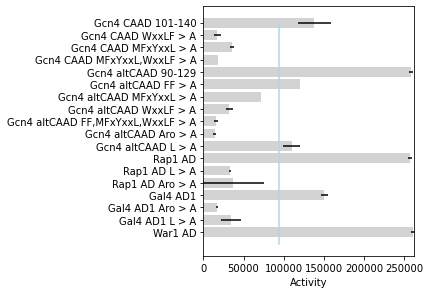

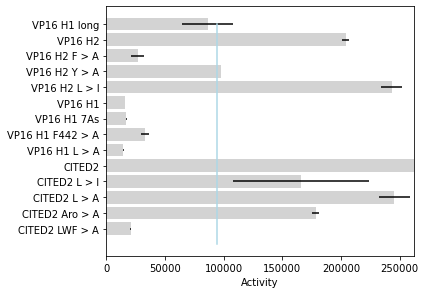

In [14]:
# yeast Controls
yeastset  = names[3:7]+names[8:15]+names[20:23] +names[0:3] +names[7:8]
plotBarGraph(yeastset,'Yeast Control ADs.pdf')
plt.show()


#human and viral conrols
humanset  = names[15:20]+names[23:32] 
plotBarGraph(humanset,'Human and Viral Control ADs.pdf')
plt.show()


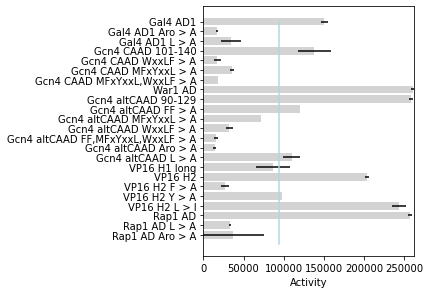

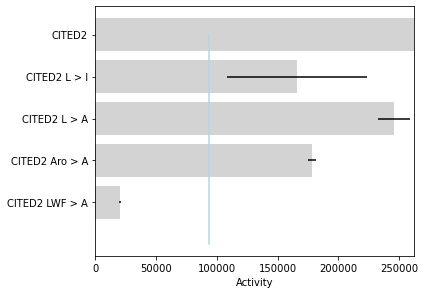

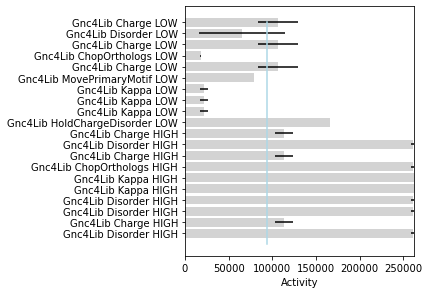

In [15]:
## plotBarGraph(names[0:15],'Yeast ADs')
plotBarGraph(names[0:23],'Yeast ADs Plus')

# plotBarGraph(names[6:14],'Gcn4 CAAD Alternative')

# findMutant('GCN4alt')

# plotBarGraph(names[loc[7,20,21,22]],'Other Yeast ADs')


plotBarGraph(names[27:32],'Cited2')

plotBarGraph(names[32:53],'Gcn4')


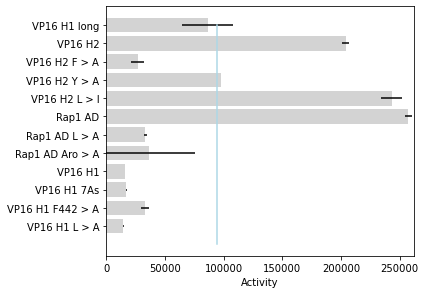

There is a design error in VP16N_L2A--the F is alo an A--it is really 7As
Name                                                                 vp16N_0
ADseq                               STAPPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDG
Activity_SCglucose                                              86353.585771
TotalReads_BioRepA_BYS4                                             141076.0
ArrayDNA                   TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATT...
Name: 20694, dtype: object
Name                                                                 VP16C_0
ADseq                               DSPGPGFTPHDSAPYGALDMADFEFEQMFTDALGIDEYGG
Activity_SCglucose                                             203815.496319
TotalReads_BioRepA_BYS4                                             106591.0
ArrayDNA                   GATTCTCCAGGTCCAGGATTTACTCCACATGATTCTGCTCCATATG...
Name: 20695, dtype: object
Name                                                             VP16C_F2A_0
ADseq                    

In [16]:

plotBarGraph(names[15:27],'VP16')
print('There is a design error in VP16N_L2A--the F is alo an A--it is really 7As' )
# findMutant('vp16N_0')

findMutant('vp16N_0',cols=['Name','ADseq','Activity_SCglucose', 'TotalReads_BioRepA_BYS4','ArrayDNA'])
findMutant('VP16',cols=['Name','ADseq','Activity_SCglucose', 'TotalReads_BioRepA_BYS4','ArrayDNA'])



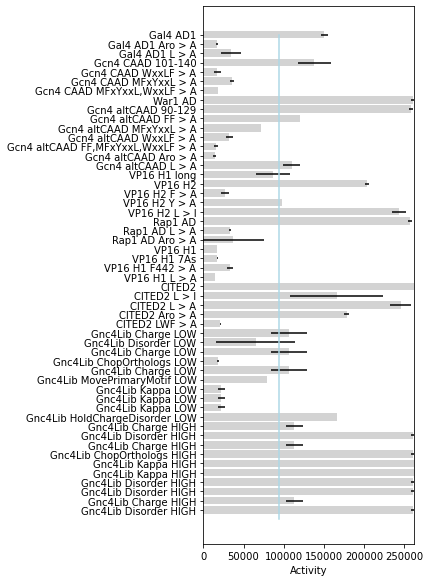

In [17]:
fig = plt.figure(figsize=(6,8))
plotBarGraph(names,'All')

In [18]:
tempDF = masterDF[masterDF.Name=='VP16N_7As_0']
print(tempDF.Name)
print(tempDF.ArrayDNA.values)
tempDNA = tempDF.ArrayDNA.values
print(tempDNA[0])
print(tempDF.ADseq)
# dna = Seq(tempDNA[0])
# translation = str(dna.translate())
# protein =tempDF.ADseq
#     if protein != translation:
#         print( row)
# print(protein)
# print(translation)
# tempDF = masterDF[masterDF.Name=='VP16N_L2A_0']
# print(tempDF.Name)
# print(tempDF.ADseq)
# print(tempDF.ArrayDNA.values)

# print(masterDF[20703,'ADseq'])

20703    VP16N_7As_0
Name: Name, dtype: object
['CCACCAACTGATGTTTCTGCTGGTGATGAAGCTCATGCTGATGGTGAAGATGTTGCTATGGCTCATGCTGATGCTGCTGATGACTTTGATGCTGATATGGCTGGTGATGGTGATTCTCCA']
CCACCAACTGATGTTTCTGCTGGTGATGAAGCTCATGCTGATGGTGAAGATGTTGCTATGGCTCATGCTGATGCTGCTGATGACTTTGATGCTGATATGGCTGGTGATGGTGATTCTCCA
20703    PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP
Name: ADseq, dtype: object


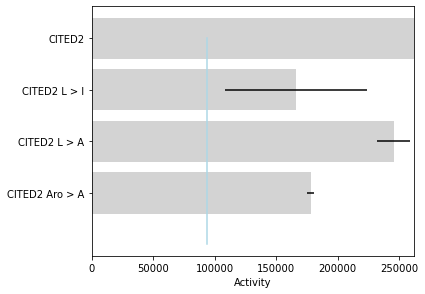

20679    150214.685930
20680     16962.199847
20681     34386.519990
20682    137982.570130
20683     17426.515045
20684     35741.083274
20685     18345.739700
20686    260331.734020
20687    258453.390222
20688    119753.509231
20689     71064.009720
20690     32126.202553
20691     15400.437967
20692     13761.263345
20693    109836.536324
20694     86353.585771
20695    203815.496319
20696     26748.695475
20697     97504.209741
20698    243013.543573
20699    257453.052184
20700     33410.885065
20701     36628.055132
20702     16429.974583
20703     17261.583866
20704     32720.434545
20705     14676.812760
20706    262003.249427
20707    165952.081484
20708    245500.369046
20709    178307.140122
20710     20699.187240
20711    122464.996923
20712     64997.041479
20713    121868.094214
20714     17838.341224
20715    106473.175517
20716     79030.855049
20717     17685.589260
20718    119962.758666
20719     22007.578853
20720    166175.360232
20721    260943.132945
20722    26

In [19]:
plotBarGraph(names[27:31],'Cited2')
Controls.Activity_SCglucose


,Activity_SCglucose,Activity_SCglucose_BYS2_PerfectMatch
Activity_SCglucose,1.000000,0.980323
Activity_SCglucose_BYS2_PerfectMatch,0.980323,1.000000


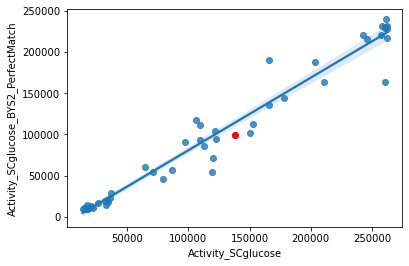

In [20]:
import seaborn as sns
col1 = 'Activity_SCglucose'
col2 ='Activity_SCglucose_BYS2_PerfectMatch' 
# col3 = 'Activity_SCglucose_BYS2_Bowtie' # had mapping problem
sns.regplot(x=col1,y =col2,data=Controls)
WT = Controls[Controls.Name=='GCN4_CAAD40_0']
plt.scatter(WT[col1],WT[col2],c='r')
plt.savefig
tempDF= Controls[[col1,col2]]
tempDF.corr()

In [21]:
oldmasterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20210128_withSeqFeatures.csv')


(0.8069740534146812, 0.0)


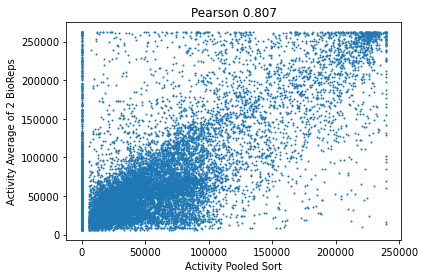

0 missing in both Seq run
1754 missing in first Seq run


In [22]:
plt.scatter(oldmasterDF.Activity_SCglucose,masterDF.Activity_SCglucose,s=1)
indx = (oldmasterDF.Activity_SCglucose>0) &(masterDF.Activity_SCglucose>0)

corr = scipy.stats.pearsonr(oldmasterDF.Activity_SCglucose[indx],masterDF.Activity_SCglucose[indx])
print(corr)
plt.title('Pearson %.3f'%corr[0])
plt.xlabel('Activity Pooled Sort'),plt.ylabel('Activity Average of 2 BioReps')
plt.show()
indx = (oldmasterDF.Activity_SCglucose==0) &(masterDF.Activity_SCglucose==0)
print('%i missing in both Seq run'%sum(indx))
indx = (oldmasterDF.Activity_SCglucose==0) &(masterDF.Activity_SCglucose>0)
print('%i missing in first Seq run'%sum(indx))
# indx = (oldmasterDF.Activity_SCglucose>0) &(masterDF.Activity_SCglucose==0)
# print('%i missing in secound Seq run'%sum(indx))
tempDF = masterDF[indx]
# plt.hist(tempDF.,50)
# plt.savefig('')
# plt.show()

In [24]:
# plt.scatter(oldmasterDF.SCglucose_TotalReads,masterDF.TotalReads_SCglucose,s=1)
# corr = scipy.stats.pearsonr(oldmasterDF.SCglucose_TotalReads,masterDF.TotalReads_SCglucose)
# print(corr)
# plt.xlabel('Total Reads old'),plt.ylabel('Total Reads new')

# Calculated activity is not correlated with Read depth

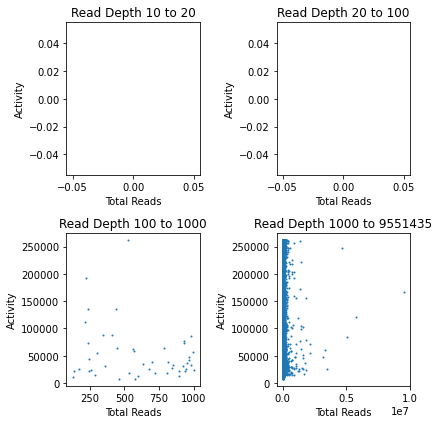

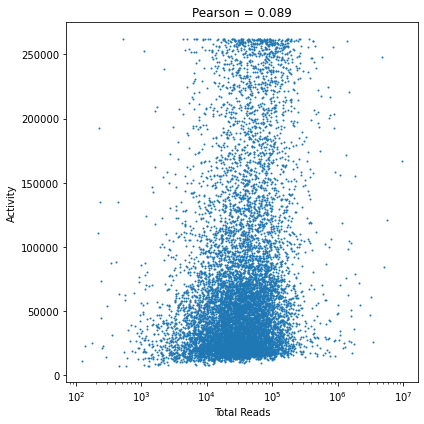

In [25]:
ranges = [10,20,100,1000,max(masterDF.TotalReads_SCglucose)+1]
f, ax = plt.subplots(figsize=(6, 6))
for i in [0,1,2,3]:
    indx = (masterDF.TotalReads_SCglucose>=ranges[i])&(masterDF.TotalReads_SCglucose<ranges[i+1])
    tempDF = masterDF[indx]
    a = tempDF.TotalReads_SCglucose
    b = tempDF.Activity_SCglucose
    plt.subplot(2,2,i+1)
    plt.scatter(a,b,s=1)
#     corr = scipy.stats.pearsonr(a,b)
    plt.title('Read Depth %i to %i'%(ranges[i],ranges[i+1]))
    plt.xlabel('Total Reads'),plt.ylabel('Activity')
    plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/ReadDepth_split.pdf')
plt.show()
tempDF = masterDF[masterDF.Recovered]#[indx]
a = tempDF.TotalReads_SCglucose
b = tempDF.Activity_SCglucose
indx = (~np.isnan(a))&(~np.isnan(b))
a = a[indx]
b = b[indx]
f, ax = plt.subplots(figsize=(6, 6))
plt.scatter(a,b,s=1,)
ax.set_xscale('log')

corr = scipy.stats.pearsonr(a,b)
plt.title('Pearson = %.3f'%corr[0])
plt.xlabel('Total Reads'),plt.ylabel('Activity')
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/ReadDepth_all.pdf')


In [26]:
SumanthOrthologList = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020.fa',expect_unique_header=False,duplicate_record_action='ignore')
SumanthOrthologListcut = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020cut.fasta',expect_unique_header=False,duplicate_record_action='ignore')
SumanthDF = pd.DataFrame.from_dict(SumanthOrthologList,orient='index')
# column_names=['Name','Sequence']
SumanthDF=SumanthDF.rename(columns={0:'Sequence'})
SumanthDF['Fullname'] = SumanthDF.index




In [27]:
species = []
for i, row in SumanthDF.iterrows():
    temp = row.Fullname.split('|')
    if len(temp)>1:
        species.append(temp[1])
    else:
        species.append(temp[0])

SumanthDF['Species'] = species

print('Total seqs %i'%len(SumanthOrthologList))
print('Unique species identifiers %i'%len(set(species)))
print('Unique protein seqs %i'%len(set(SumanthDF.Sequence)))

Total seqs 1188
Unique species identifiers 132
Unique protein seqs 502


In [28]:
species = []
FullOrthoDF =  pd.read_pickle('../Data/Processed/FullOrthologDF_20230414')
for i, row in FullOrthoDF.iterrows():
    temp = row.SpeciesName.split('|')
    if len(temp)>1:
        species.append(temp[1])
    else:
        species.append(temp[0])

print('Total seqs %i'%len(FullOrthoDF))
print('Unique species identifiers %i'%len(set(species)))
# print('Unique protein seqs %i'%len(set(FullOrthoDF.Sequence)))

Total seqs 502
Unique species identifiers 129


# Counting the unique species in the Full Ortholog DF is more reliable. 
Use 129 as number of proteomes in the manuscript

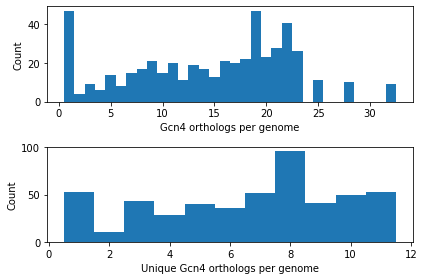

In [29]:
seqs_per_genome, uniques_per_genome = [],[]
for name in species:
    indx = SumanthDF.Species ==name
    tempDF=SumanthDF[indx]
    seqs_per_genome.append(len(tempDF.Sequence))
    uniques_per_genome.append(len(set(tempDF.Sequence)))
# print(%i genomes
plt.subplot(2,1,1)
b = plt.hist(seqs_per_genome,bins = np.linspace(0.5,32.5,33))
plt.xlabel('Gcn4 orthologs per genome'),plt.ylabel('Count')
plt.subplot(2,1,2)
a = plt.hist(uniques_per_genome,bins = np.linspace(0.5,11.5,num=12))
plt.xlabel('Unique Gcn4 orthologs per genome'),plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Figures/OrthologsPerGenome.pdf')

# new data is reasonably similar to the 2018 data

Found 334 matches
There are 312 unique NEW seqs
There are 297 unique OLD seqs
(0.7857817254950228, 2.955507599674453e-71)
Pearson = 0.785782
Spearman = 0.731280


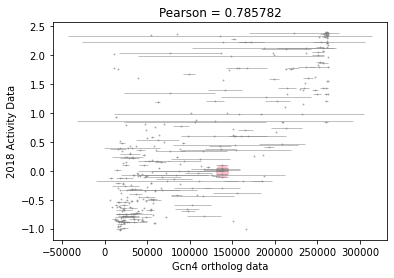

/Users/maxstaller/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


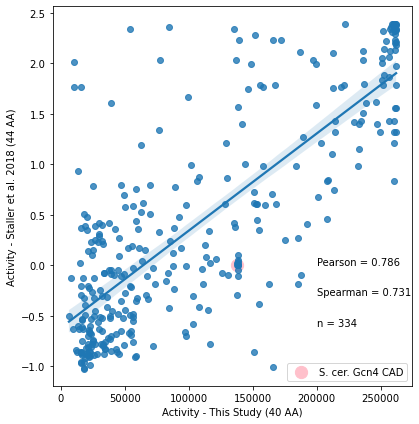

In [43]:
PublishedGcn4Data = pd.read_csv('../Data/Staller_2018data/Supplemental_DataTable1_ActivityData.csv')
indx = (PublishedGcn4Data.VeryHighStringencySet)&~np.isnan(PublishedGcn4Data.ActivityCompleteMediaReplicate1_Normalized)
tempDF =PublishedGcn4Data[PublishedGcn4Data.VeryHighStringencySet]
OldData = dict(zip(tempDF.ActivationDomainSeq,tempDF.ActivityCompleteMediaReplicate1_Normalized))
tempDF =masterDF[masterDF.Recovered]
NewData = dict(zip(tempDF.ADseq,tempDF.Activity_SCglucose))
NewErrors = dict(zip(tempDF.ADseq,tempDF.Stdev_BYS4_BioReps))
HoldPairs,holdX,holdY,errors =[],[],[],[]
HoldOldSeqs, HoldNewSeqs = [],[]
for seq1 in NewData.keys():
    for seq2 in OldData.keys():
        if seq1 in seq2:
            if ~np.isnan(OldData[seq2]):
                HoldPairs.append([seq1,seq2])
                HoldOldSeqs.append(seq2)
                HoldNewSeqs.append(seq1)
                holdX.append(NewData[seq1])
                holdY.append(OldData[seq2])
                errors.append(NewErrors[seq1])
print('Found %i matches'%len(HoldPairs))
print('There are %i unique NEW seqs'%len(set(HoldNewSeqs)))
print('There are %i unique OLD seqs'%len(set(HoldOldSeqs)))
ScerWTactivity = np.mean(masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK']['Activity_SCglucose'])
ScerWTactivity
holdX = np.array(holdX)
holdY = np.array(holdY)
# plt.scatter(holdX,holdY,s=1)
plt.errorbar(holdX,holdY,xerr=errors,fmt='o',capsize=0, elinewidth=1,c='gray',ms=1,alpha=.5)
plt.ylabel('2018 Activity Data'),plt.xlabel('Gcn4 ortholog data')
corr = scipy.stats.pearsonr(holdX,holdY)
plt.scatter(ScerWTactivity,0,s=150,c='pink')
print(corr)
print('Pearson = %f'%corr[0])
plt.title('Pearson = %f'%corr[0])
corrS = scipy.stats.spearmanr(holdX,holdY)
print('Spearman = %f'%corrS[0])
plt.show()
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 6))
plt.scatter(ScerWTactivity,0,s=150,c='pink',label='S. cer. Gcn4 CAD')
sns.regplot(holdX,holdY,)
plt.text(200000,0,'Pearson = %.3f'%corr[0])
plt.text(200000,-0.3,'Spearman = %.3f'%corrS[0])
plt.text(200000,-0.6,'n = %i'%len(HoldPairs))
plt.xlabel('Activity - This Study (40 AA)')
plt.ylabel('Activity - Staller et al. 2018 (44 AA)')
plt.legend()
# plt.title('Compare to 2018 data')
plt.tight_layout()
plt.savefig('Figures/Controls_Measurement/CompareStudies.pdf')

/Users/maxstaller/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


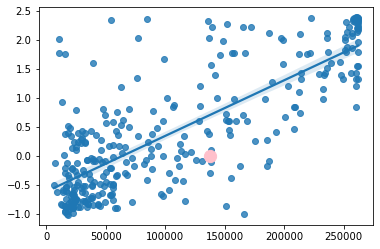

In [31]:
import seaborn as sns
sns.regplot(holdX,holdY)
plt.scatter(ScerWTactivity,0,s=150,c='pink',)



In [32]:
Activity = 'Activity_SCglucose'
# how many very high activity ADs--saturating activity
indx = (masterDF[Activity] >=( (max(masterDF[Activity]))) )
print('There are %i ADs with saturated max activity'%sum(indx))
# indx = (masterDF[Activity] >=( (max(masterDF[Activity]))) )&(masterDF['W..LF']>0)
# print('There are %i ADs with saturated max activity and the WxxLF motif'%sum(indx))
# tempDF =masterDF[indx]
# tempDF

# exportfilename = 'ExportedSeqLists/SaturatedMeasurments_WxxLF.fasta'
# tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
# protfasta.write_fasta(tempDict,exportfilename)

# indx = (masterDF[Activity] >=( (max(masterDF[Activity]))) )&(masterDF['W..LF']==0)
# print('There are %i ADs with saturated max activity without the WxxLF motif'%sum(indx))
# tempDF =masterDF[indx]
# exportfilename = 'ExportedSeqLists/SaturatedMeasurments_without_WxxLF.fasta'
# tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
# protfasta.write_fasta(tempDict,exportfilename)


There are 47 ADs with saturated max activity


In [33]:
sum(np.isnan(masterDF.Activity_SCglucose))

1784

# Compare Activity (Ratio sort) to GFP only and mCherry only 

In [34]:
# AllChannels_2Bioreps = pd.read_csv('../Data/ReproducibilitySort/pm_gcn4_sort2_pools_allchannels.csv')
# AllChannels_2Bioreps.columns
# tempSeries = masterDF.ArrayDNA
# for col in ['Activity_ratioA', 'Activity_ratioB',
#             'Activity_gfpA', 'Activity_gfpB', 
#             'Activity_cherryA',       'Activity_cherryB']:
#     tempDict = dict(zip(AllChannels_2Bioreps.ArrayDNA,AllChannels_2Bioreps[col]))
#     masterDF[col]=tempSeries.map(tempDict)


In [35]:
# AllChannels_2Bioreps.drop(columns=['Unnamed: 0'],inplace=True)
# pd.plotting.scatter_matrix(AllChannels_2Bioreps, alpha=0.5, figsize=(12,12))
# plt.show()

In [36]:
for item in ['TotalReads_BioRepA_BYS4','TotalReads_BioRepA_BYS4']:#,'Activity_BioRepB_BYS4','Activity_ratioB']:
    print(item)
    temp = masterDF[masterDF[item]>0]
    print('Min Read Count = %i'%min(temp[item]))

print('gcn4_deep.csv Biorep A N = %i'%sum(masterDF.Activity_BioRepA_BYS4>0))
print('gcn4_deep.csv Biorep B N = %i'%sum(masterDF.Activity_BioRepB_BYS4>0))
print('pm_gcn4_sort2_pools.csv Biorep A N = %i'%sum(AllChannels_2Bioreps.Activity_ratioA>0))
print('pm_gcn4_sort2_pools.csv Biorep B N = %i'%sum(AllChannels_2Bioreps.Activity_ratioB>0))



TotalReads_BioRepA_BYS4
Min Read Count = 41
TotalReads_BioRepA_BYS4
Min Read Count = 41
gcn4_deep.csv Biorep A N = 15032
gcn4_deep.csv Biorep B N = 14770


NameError: name 'AllChannels_2Bioreps' is not defined

In [38]:
def plotPairWiseCorr(col1,col2):
    masterDF.plot.scatter(x=col1,y=col2,s=1,figsize=(6, 6))
    temp = masterDF[[col1,col2]]
    a = temp.corr()
    indx =( temp[col1] > 0) &(temp[col2]>0)
    plt.title('Pearson R = %.3f N = %i ' % (a.values[0,1],sum(indx)))
    plt.tight_layout()
    plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility_%s_%s.pdf'%(col1,col2))

# # Compare two processing versions of the data. Main difference is the minimm read threshold for inclusion
# plotPairWiseCorr('Activity_BioRepA_BYS4','Activity_ratioA')
# plotPairWiseCorr('Activity_BioRepB_BYS4','Activity_ratioB')

In [39]:
masterDF.columns

Index(['Unnamed: 0', 'ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', '(20703, 'Name')', '(20707, 'Name')', 'Start',
       'Recovered', 'Charge', 'HydrophobicityKD', 'HydrophobicityWW', 'Kappa',
       'Omega', 'OmegaWFY_DE', 'OmegaWFYL_DE', 'OmegaWF_D', 'Disorder', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y', 'Aromatics', 'WFYL', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WF]',
       '[DE][L]', '[DE].[WFY]', '[DE]..[WFY]', 'FF', 'F.F', 'F..F',
       '[FY].....[FY]DF', 'D.F', 'D..F', 'FD', 

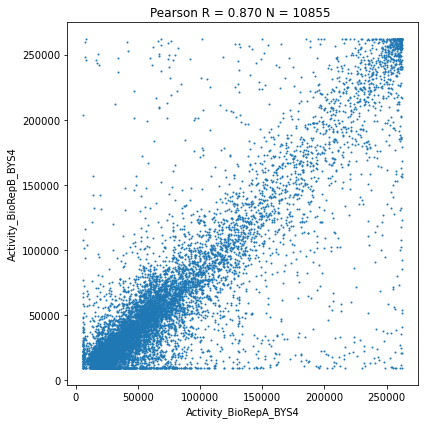

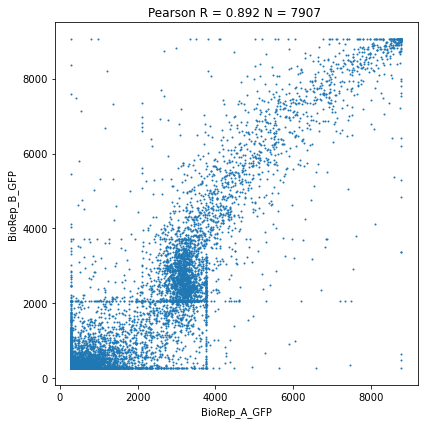

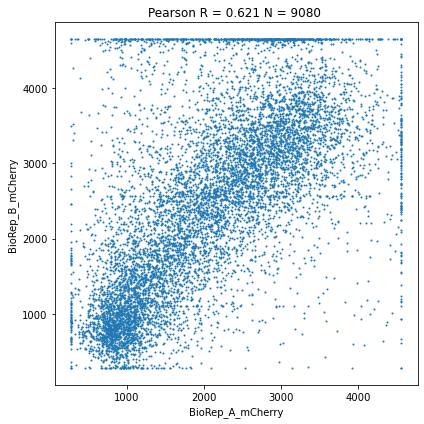

In [40]:
sets = [['Activity_BioRepA_BYS4','Activity_BioRepB_BYS4'],
            ['BioRep_A_GFP', 'BioRep_B_GFP'], 
            ['BioRep_A_mCherry',       'BioRep_B_mCherry']]
for myset in sets:
    plotPairWiseCorr(myset[0],myset[1])

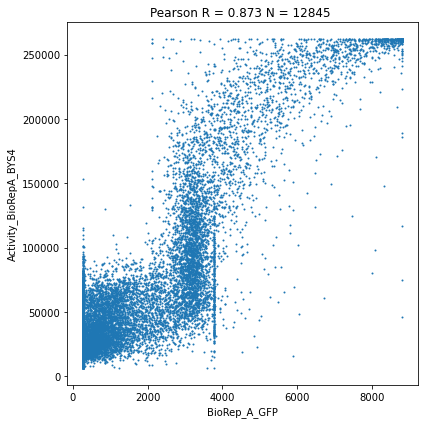

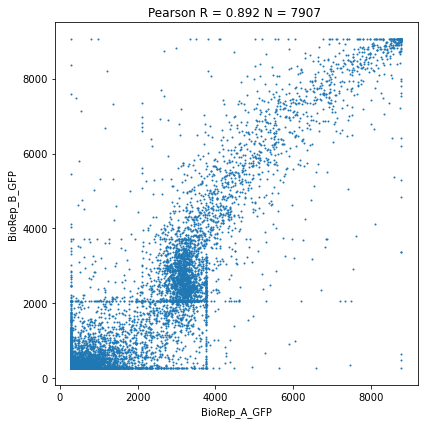

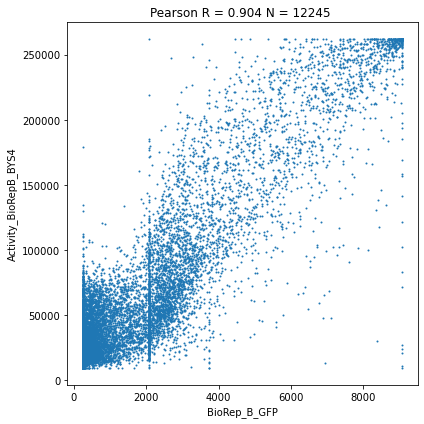

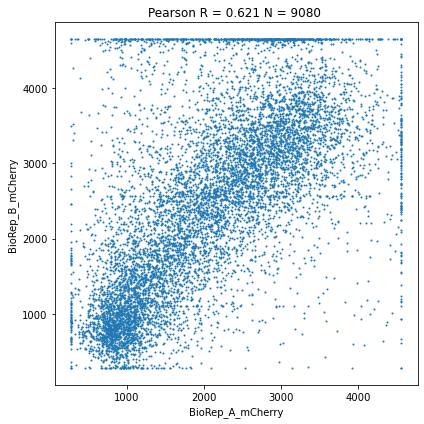

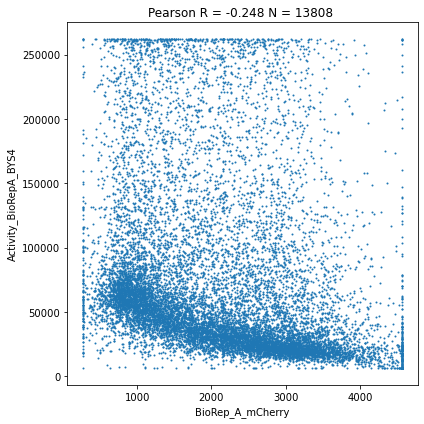

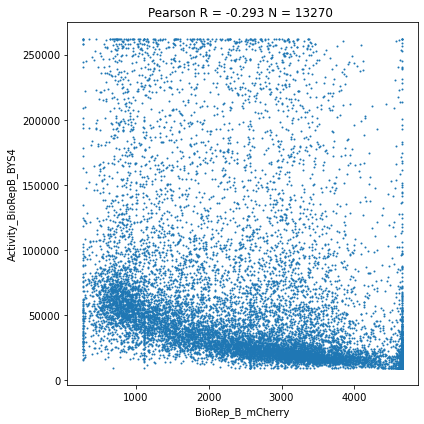

In [42]:
sets = [['BioRep_A_GFP','Activity_BioRepA_BYS4'],
        ['BioRep_A_GFP', 'BioRep_B_GFP'],
        ['BioRep_B_GFP','Activity_BioRepB_BYS4'],
        ['BioRep_A_mCherry','BioRep_B_mCherry'],
       ['BioRep_A_mCherry','Activity_BioRepA_BYS4'],
        ['BioRep_B_mCherry','Activity_BioRepB_BYS4']]

for myset in sets:
    plotPairWiseCorr(myset[0],myset[1])

In [ ]:
#Compare the mating replicates. Same library mated to same reporter 2x. It's a technical replicate for mating.
# sort of like a biological replicate but only for mating variation. 
KatDataWeijingProcess = pd.read_csv('Weijing/activity_p3_0913_colrenamed.csv')
KatDataWeijingProcess['KF_WT_Activity_P3']=KatDataWeijingProcess['Activity']
tempSeries = masterDF.ArrayDNA
for col in ['KF_WT_Activity_P3']:
    tempDict = dict(zip(KatDataWeijingProcess.ArrayDNA,KatDataWeijingProcess[col]))
    masterDF[col]=tempSeries.map(tempDict)

In [ ]:
plotPairWiseCorr('Activity_SCglucose','KF_WT_Activity_P3')
plotPairWiseCorr('Activity_SCglucose_BYS2_PerfectMatch','KF_WT_Activity_P3')


# compare reprocessed data to the original processing runs


In [ ]:
tileDF_MZ = pd.read_csv('../Data/Zintel_Reprocess202409/BYS4combined_bothredoseqsincluded.csv')

In [ ]:
tileDF_MZ.columns
tempSeries = masterDF.ArrayDNA
for col in ['Activity_3ARatio', 'Activity_6BRatio',
            'Activity_3ARatio_redoseq_original', 'Activity_3ARatio_redoseq',
            'Activity_6BRatio_redoseq_original', 'Activity_6BRatio_redoseq'
#             'Activity_cherryA',       'Activity_cherryB'
           ]:
    tempDict = dict(zip(tileDF_MZ.DNAseq,tileDF_MZ[col]))
    masterDF[col]=tempSeries.map(tempDict)

In [ ]:
def plotPairWiseCorr(col1,col2):
    masterDF.plot.scatter(x=col1,y=col2,s=1,figsize=(6, 6))
    temp = masterDF[[col1,col2]]
    a = temp.corr()
    indx =( temp[col1] > 0) &(temp[col2]>0)
    plt.title('Pearson R = %.3f N = %i ' % (a.values[0,1],sum(indx)))
    plt.tight_layout()
    plt.savefig('Figures/Controls_Measurement/BioRep_Reproducibility_%s_%s.pdf'%(col1,col2))

# Compare two processing versions of the data. Main difference is the minimm read threshold for inclusion
plotPairWiseCorr('Activity_BioRepA_BYS4','Activity_ratioA')
plotPairWiseCorr('Activity_BioRepA_BYS4','Activity_3ARatio')
plotPairWiseCorr('Activity_3ARatio','Activity_ratioA')
plotPairWiseCorr('Activity_3ARatio','Activity_3ARatio_redoseq_original')
plotPairWiseCorr('Activity_BioRepA_BYS4','Activity_3ARatio_redoseq_original')






In [ ]:
plotPairWiseCorr('Activity_BioRepB_BYS4','Activity_6BRatio')
plotPairWiseCorr('Activity_BioRepB_BYS4','Activity_ratioB')
plotPairWiseCorr('Activity_BioRepB_BYS4','Activity_6BRatio_redoseq')
plotPairWiseCorr('Activity_6BRatio','Activity_6BRatio_redoseq')

In [ ]:
temp = masterDF[['Activity_BioRepA_BYS4','Activity_ratioA','Activity_3ARatio','Activity_3ARatio_redoseq']]
pd.plotting.scatter_matrix(temp)
plt.show()
temp = masterDF[['Activity_BioRepB_BYS4','Activity_6BRatio','Activity_6BRatio_redoseq']]
pd.plotting.scatter_matrix(temp)